In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format = "retina"

register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
column_names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis"]

df = pd.read_csv("./WISDM_ar_latest/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header = None, names = column_names)
df.z_axis.replace(regex = True, inplace = True, to_replace = r';', value = r'')
df["z_axis"] = df.z_axis.astype(np.float64)
df.dropna(axis = 0, how = "any", inplace = True)

print(df.head())
print(df.shape)

   user_id activity       timestamp    x_axis     y_axis    z_axis
0       33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1       33  Jogging  49106062271000  5.012288  11.264028  0.953424
2       33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3       33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4       33  Jogging  49106332290000 -1.184970  12.108489  7.205164
(1098203, 6)


<AxesSubplot:xlabel='activity', ylabel='count'>

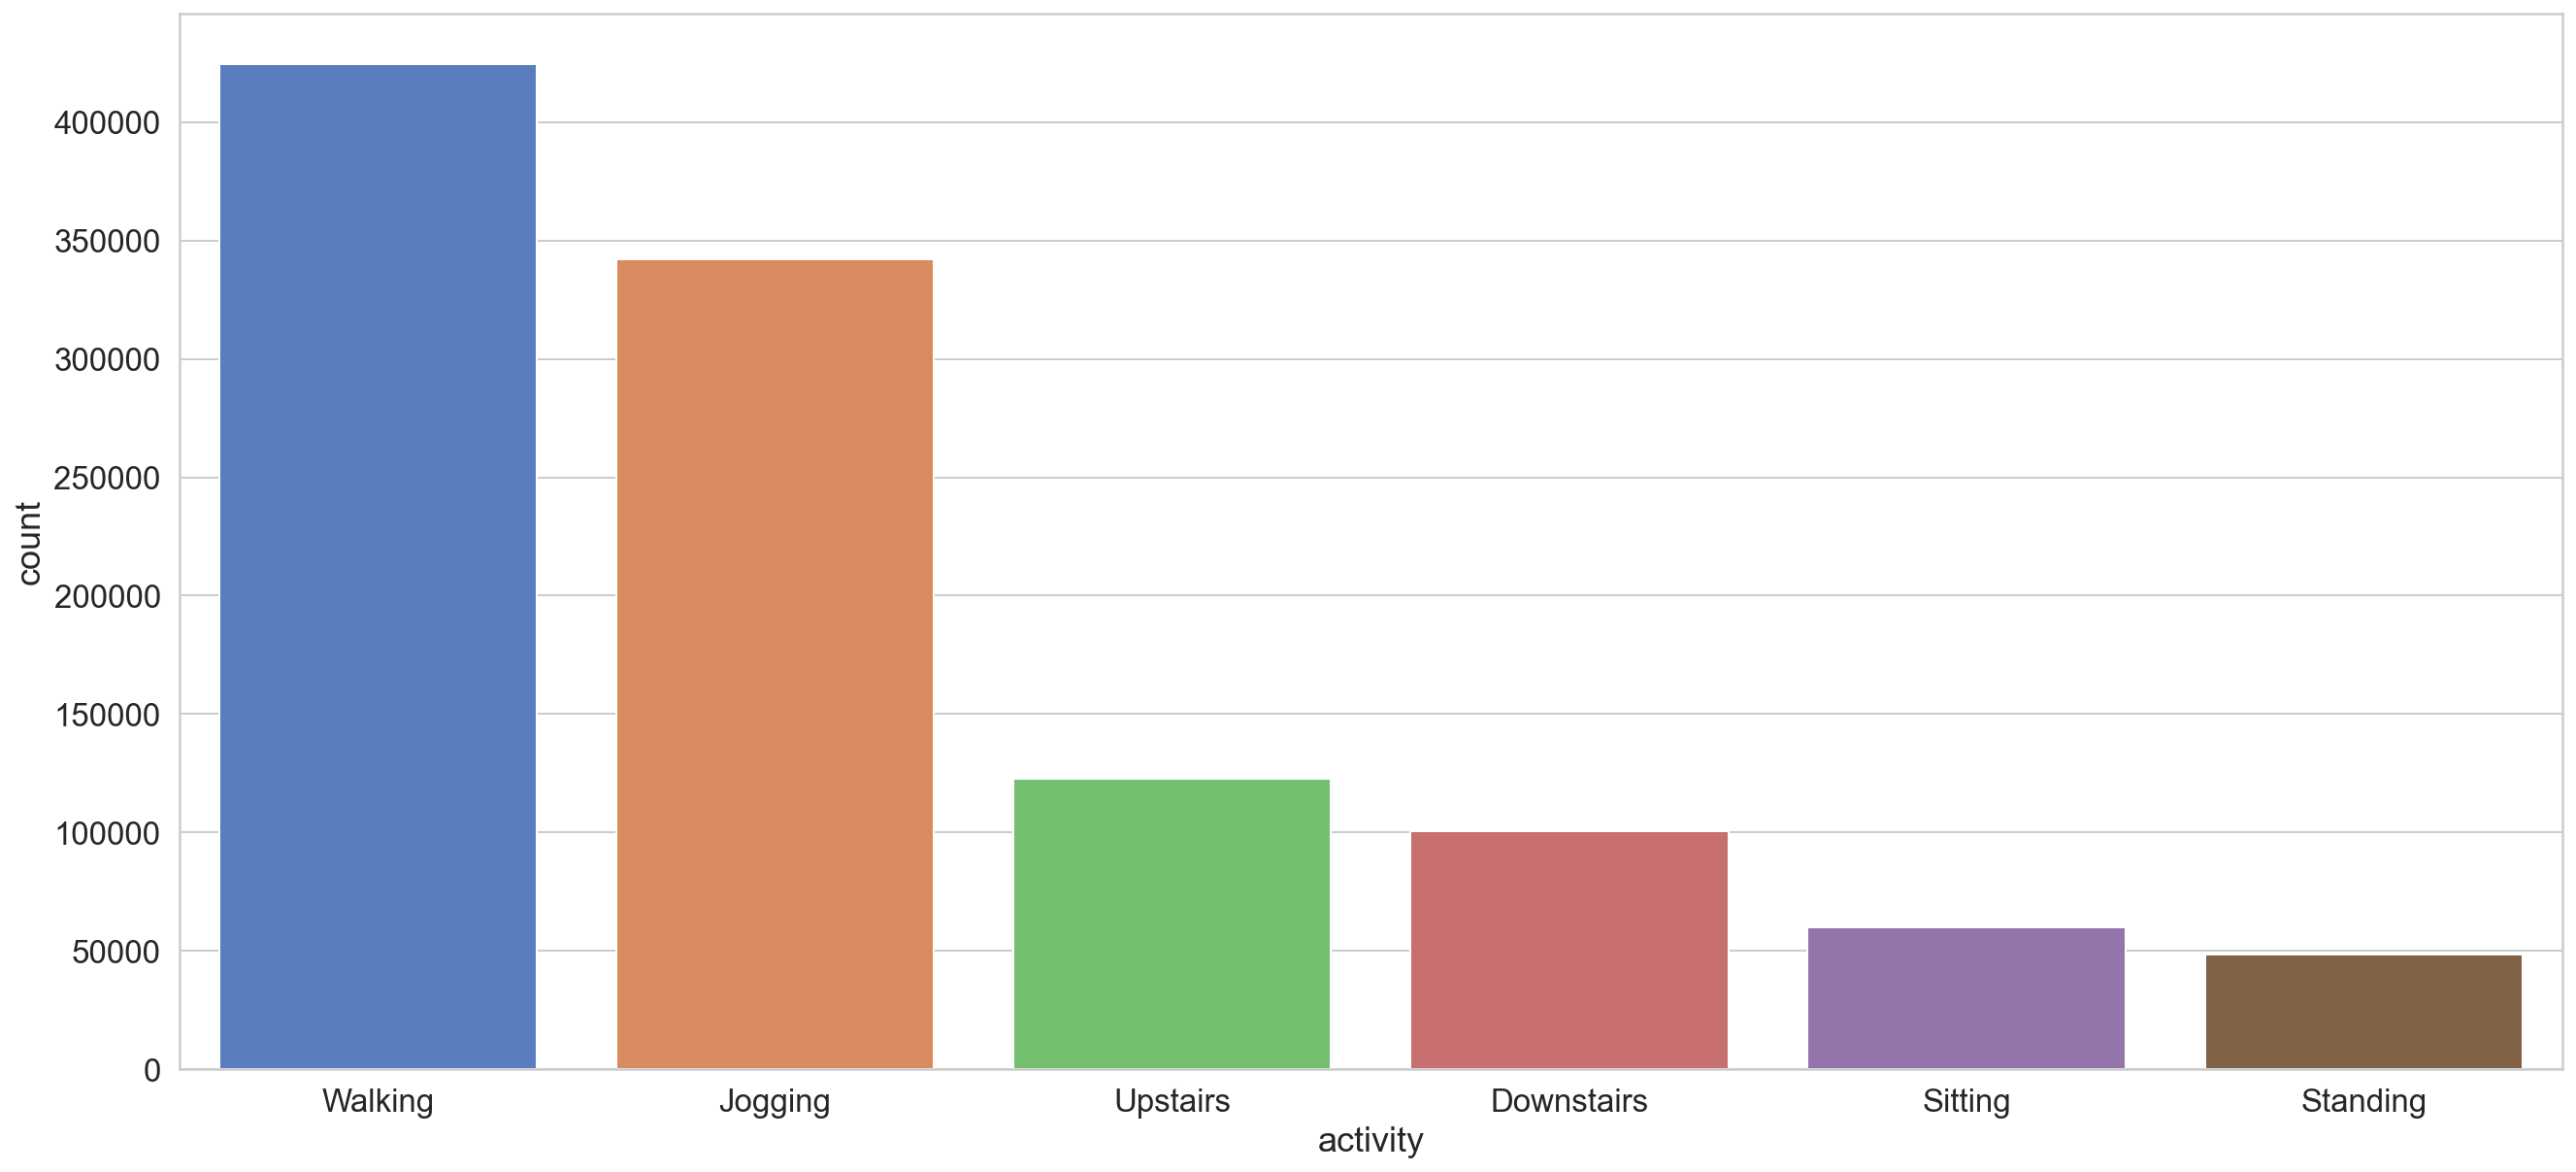

In [3]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

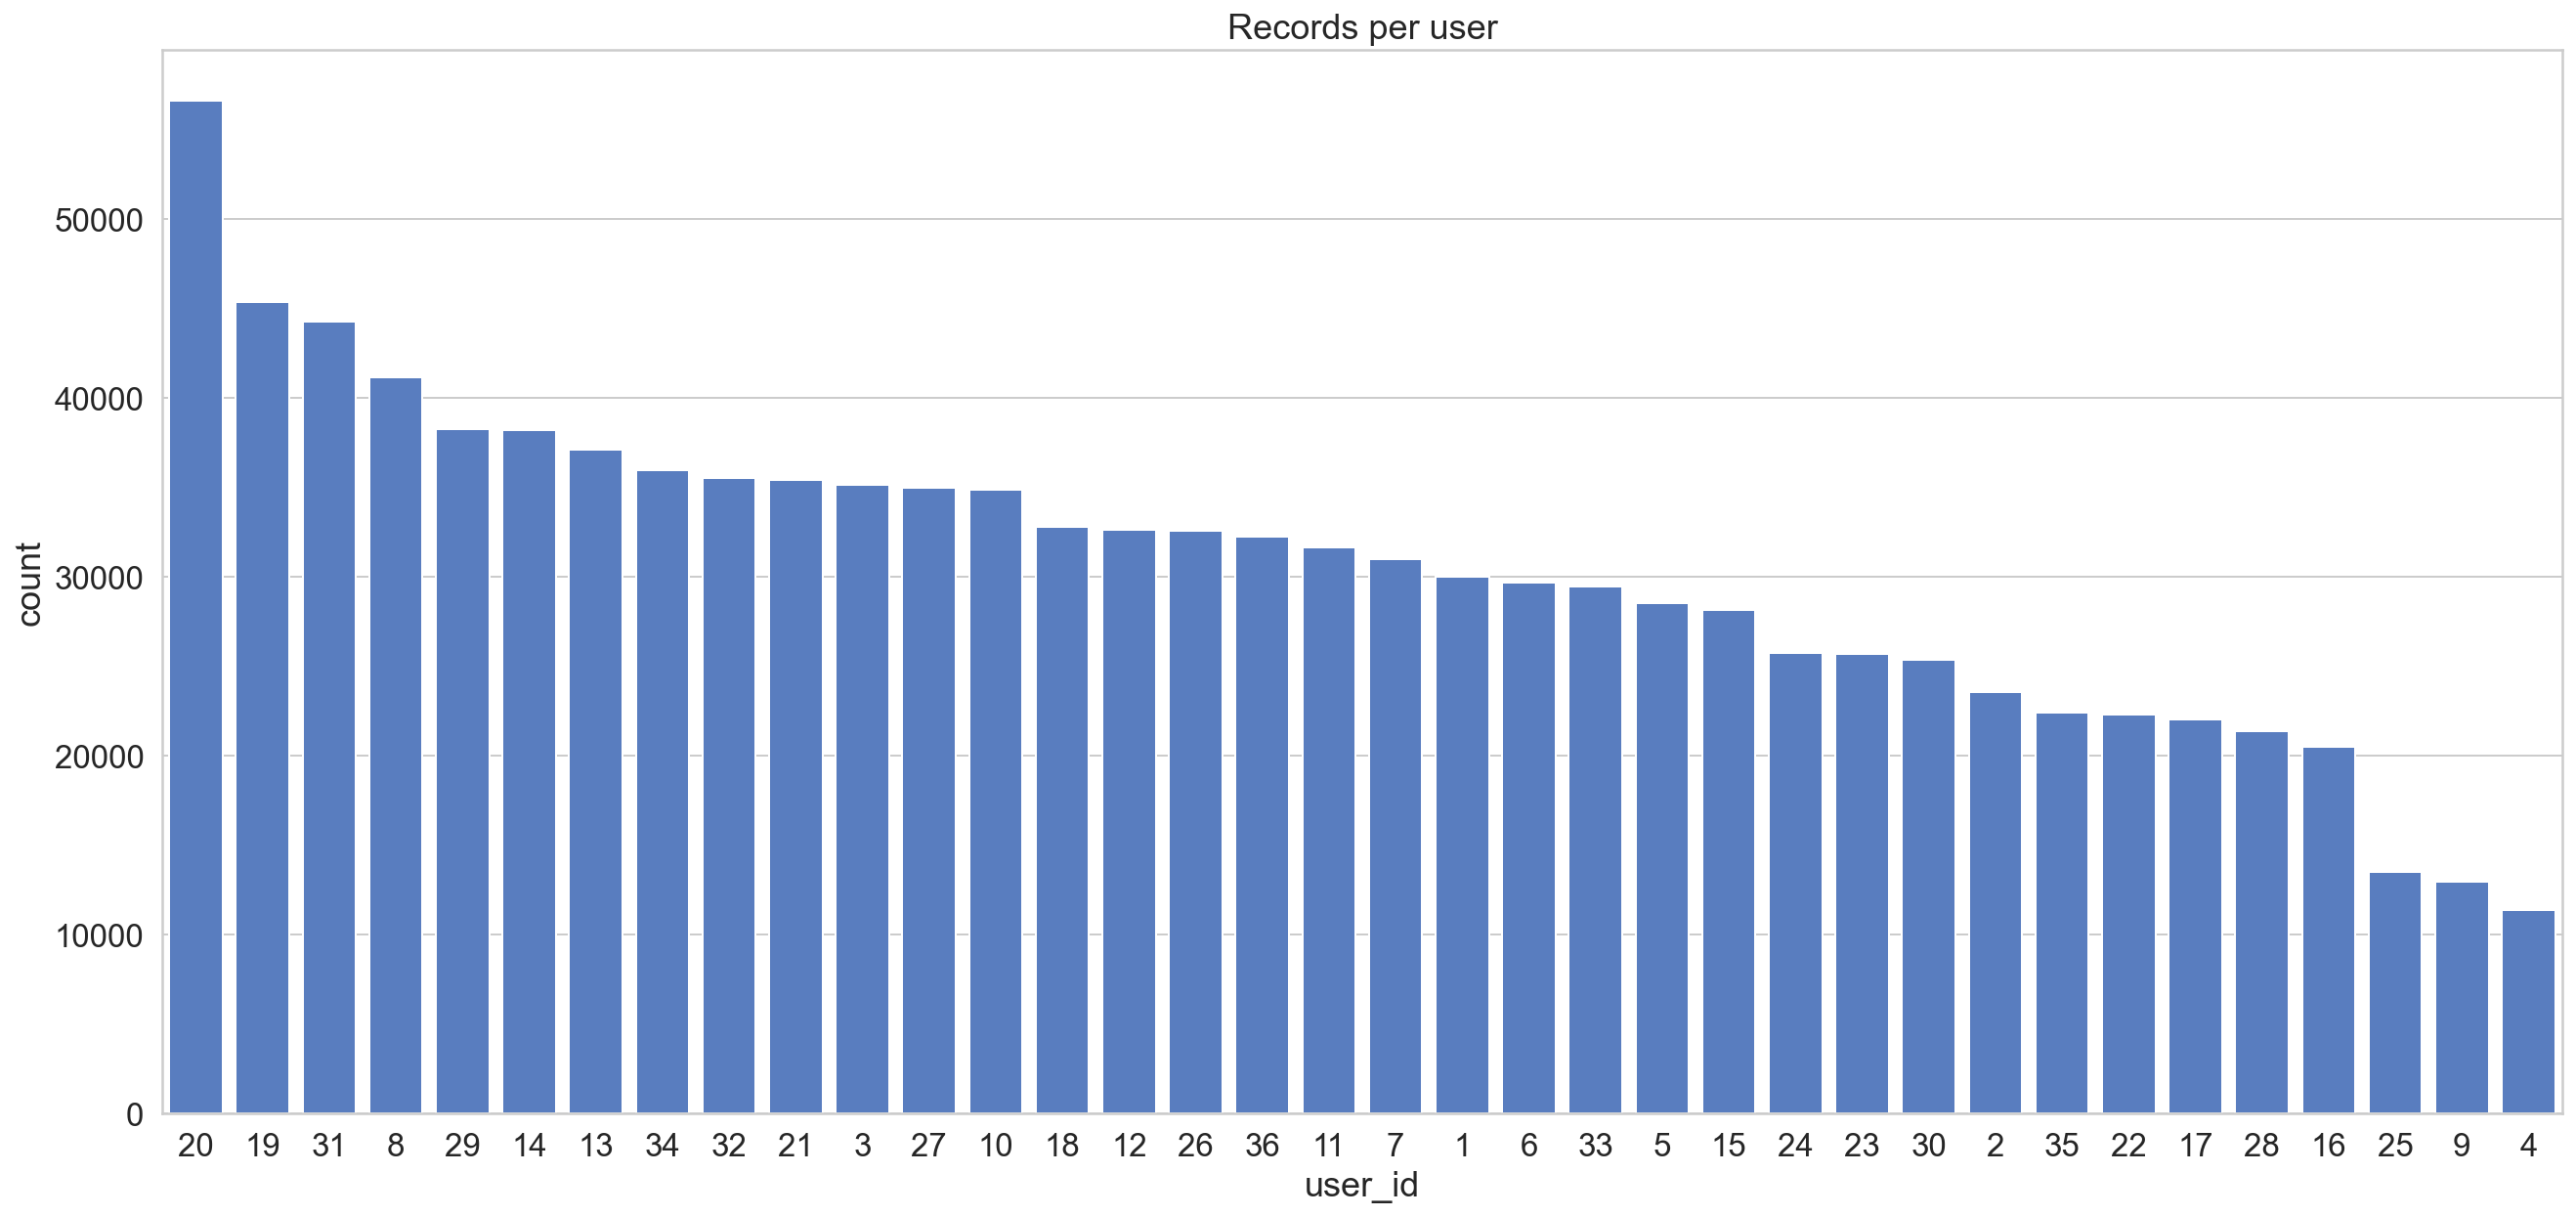

In [4]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");

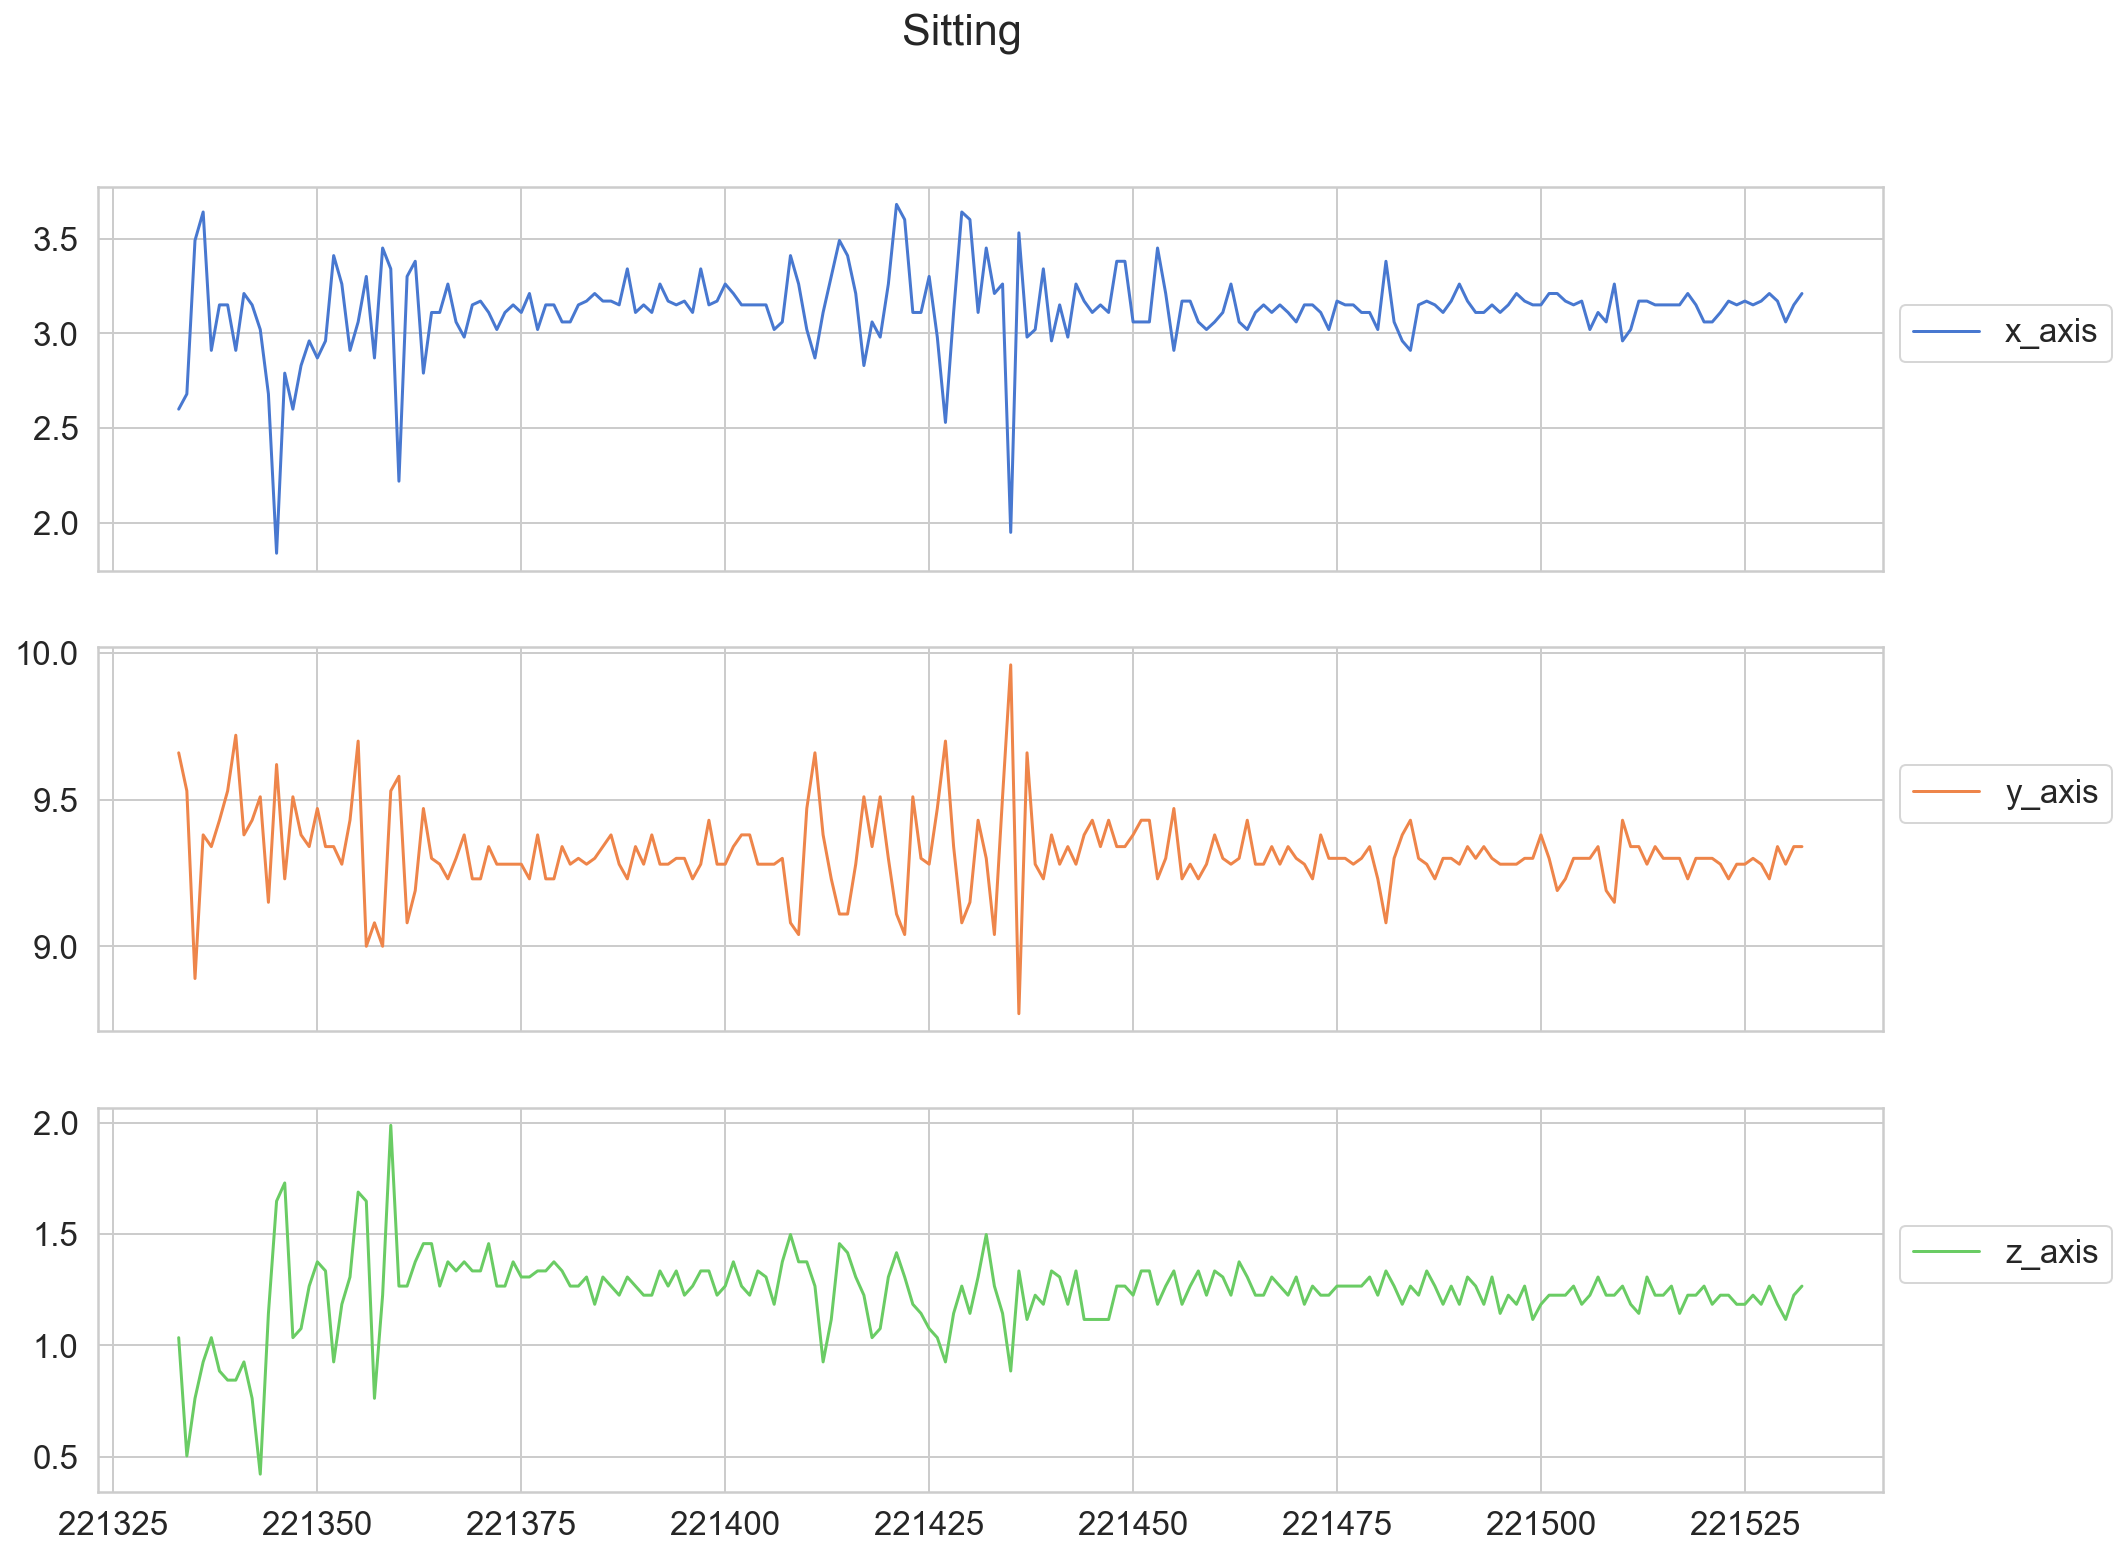

In [5]:
def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))
        
plot_activity("Sitting", df)

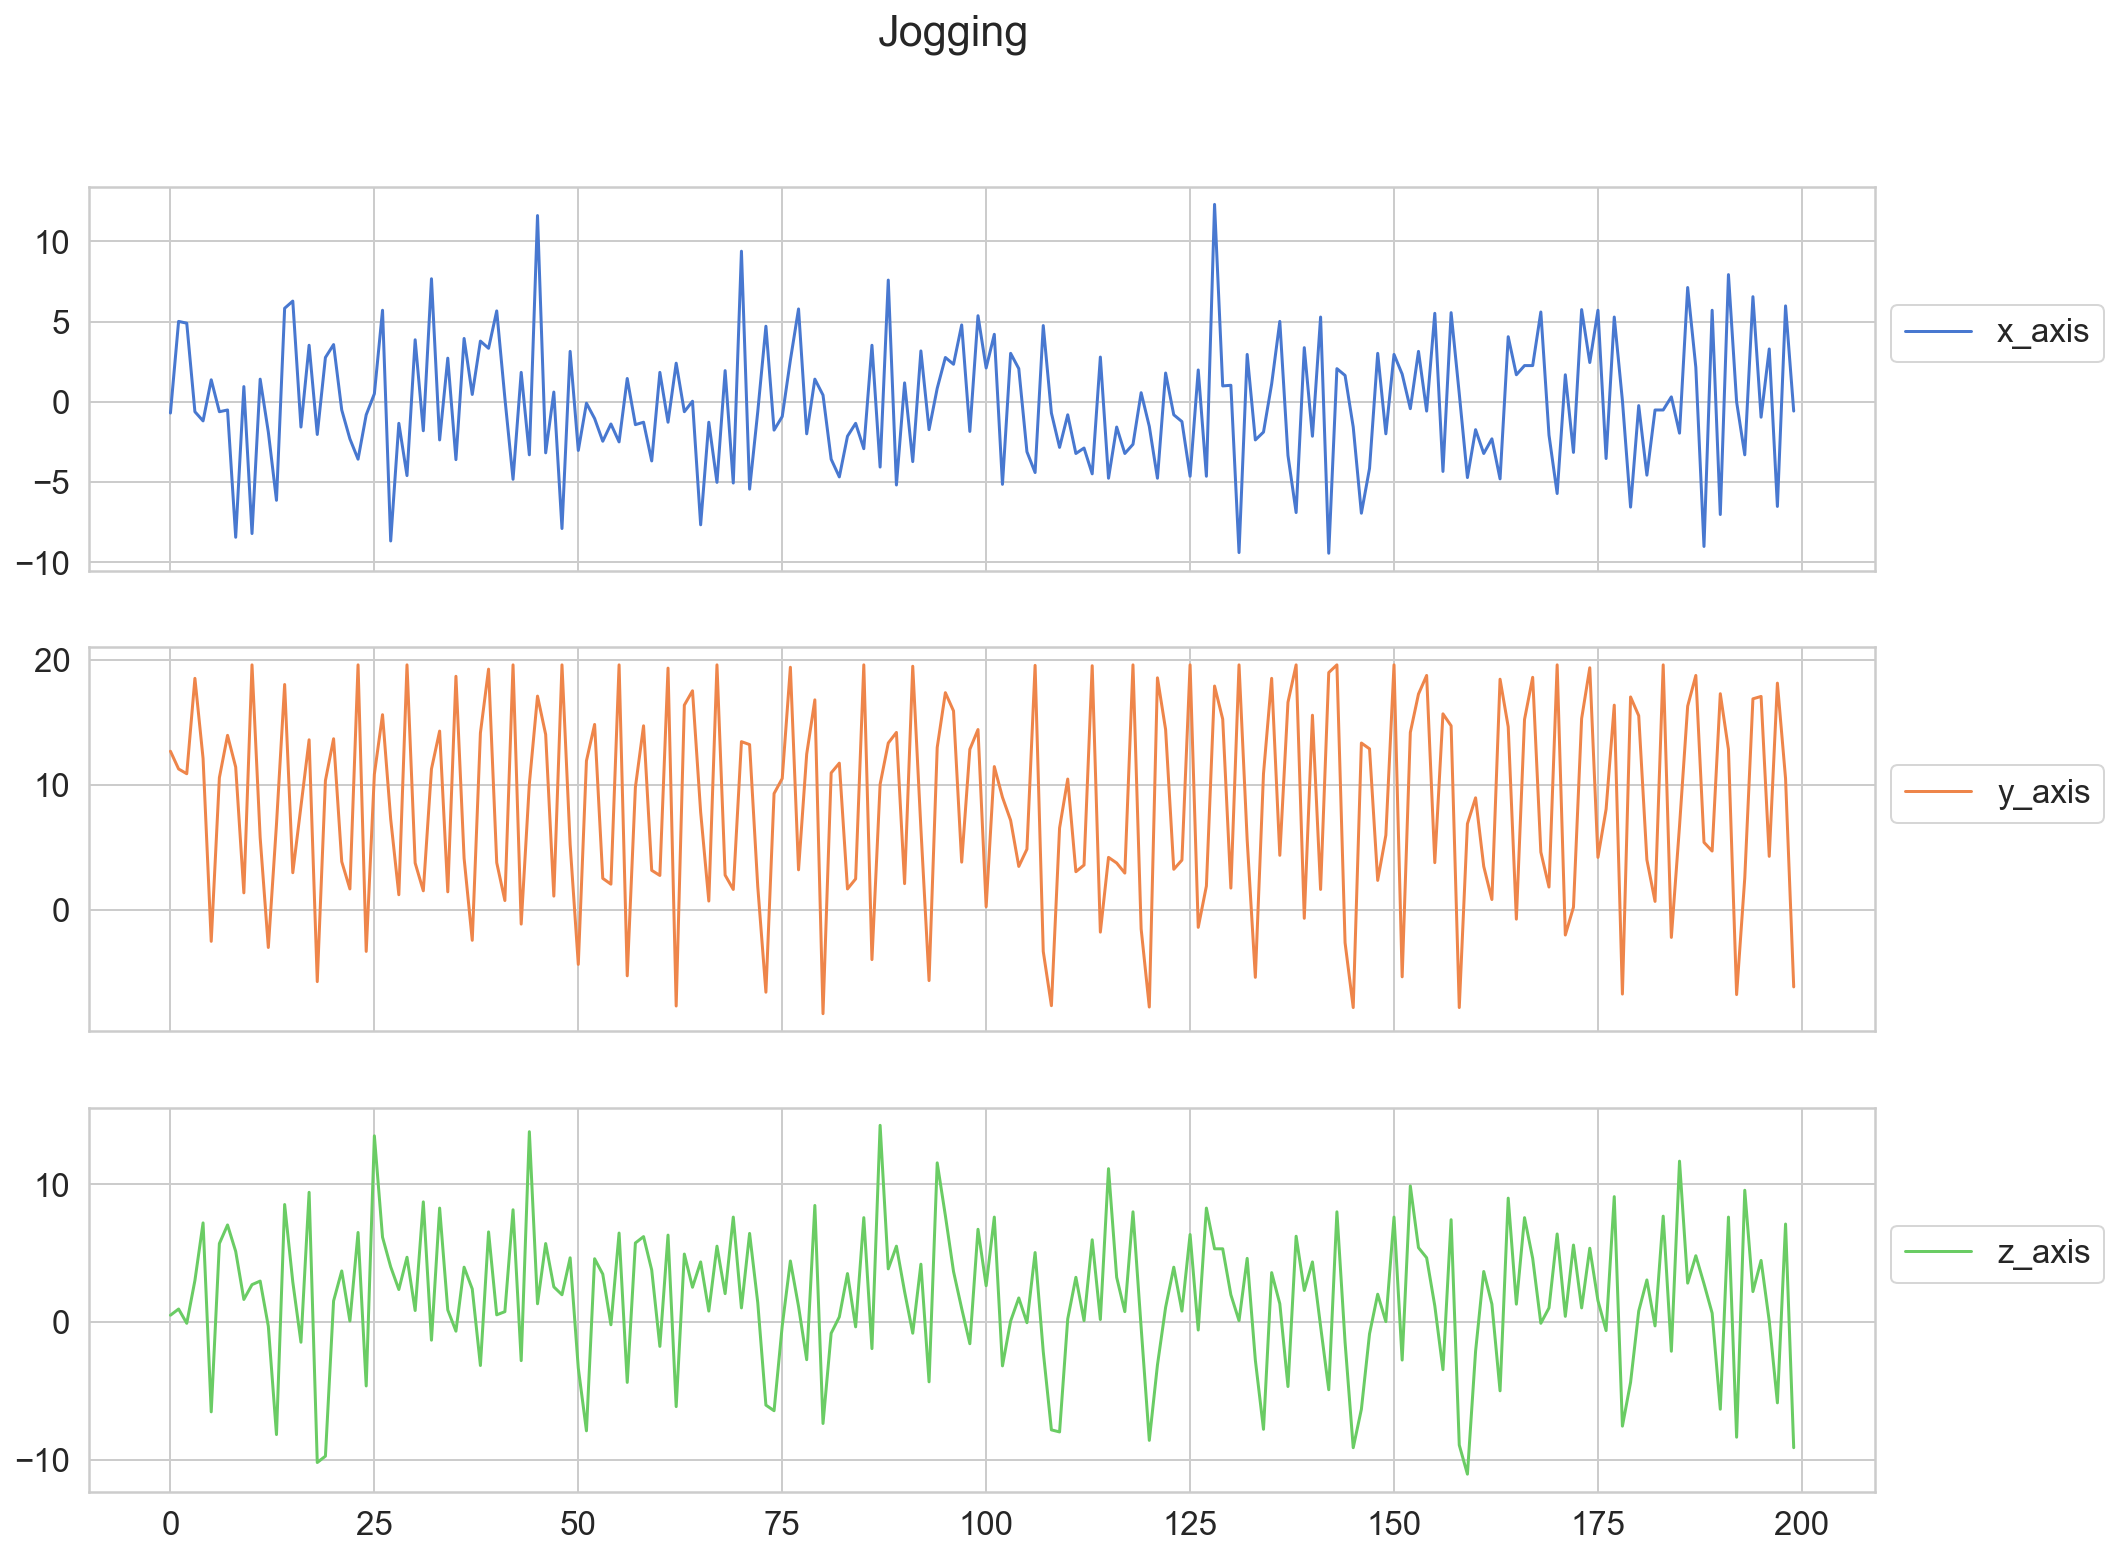

In [6]:
plot_activity("Jogging", df)

In [7]:
df_train = df[df["user_id"] <= 30]
df_test = df[df["user_id"] > 30]

In [8]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

/home/vaibhav/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1737: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/home/vaibhav/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1737: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [9]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(df_train[["x_axis", "y_axis", "z_axis"]], df_train.activity, TIME_STEPS,
                                  STEP)
X_test, y_test = create_dataset(df_test[["x_axis", "y_axis", "z_axis"]], df_test.activity, TIME_STEPS, STEP)

print(X_train.shape, y_train.shape)

(22454, 200, 3) (22454, 1)


In [10]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

print(X_train.shape, y_train.shape)

(22454, 200, 3) (22454, 6)


In [11]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(units = 128, input_shape = [X_train.shape[1], X_train.shape[2]])
    )
)
model.add(keras.layers.Dropout(rate = 0.5))
model.add(keras.layers.Dense(units = 128, activation = "relu"))
model.add(keras.layers.Dense(y_train.shape[1], activation = "softmax"))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["acc"])

history = model.fit(X_train, y_train, epochs = 20, batch_size = 64, validation_split = 0.1, shuffle = True)

Epoch 1/20
316/316 [==============================] - 120s 367ms/step - loss: 1.1959 - acc: 0.5820 - val_loss: 1.1990 - val_acc: 0.5356
Epoch 2/20
316/316 [==============================] - 105s 332ms/step - loss: 0.8910 - acc: 0.6960 - val_loss: 0.8754 - val_acc: 0.7346
Epoch 3/20
316/316 [==============================] - 105s 334ms/step - loss: 0.6967 - acc: 0.7509 - val_loss: 0.5182 - val_acc: 0.8473
Epoch 4/20
316/316 [==============================] - 105s 332ms/step - loss: 0.5215 - acc: 0.8050 - val_loss: 0.5171 - val_acc: 0.8451
Epoch 5/20
316/316 [==============================] - 105s 332ms/step - loss: 0.4582 - acc: 0.8243 - val_loss: 0.3147 - val_acc: 0.8869
Epoch 6/20
316/316 [==============================] - 106s 336ms/step - loss: 0.3853 - acc: 0.8507 - val_loss: 0.4502 - val_acc: 0.8593
Epoch 7/20
316/316 [==============================] - 106s 336ms/step - loss: 0.3224 - acc: 0.8727 - val_loss: 0.4827 - val_acc: 0.8584
Epoch 8/20
316/316 [============================

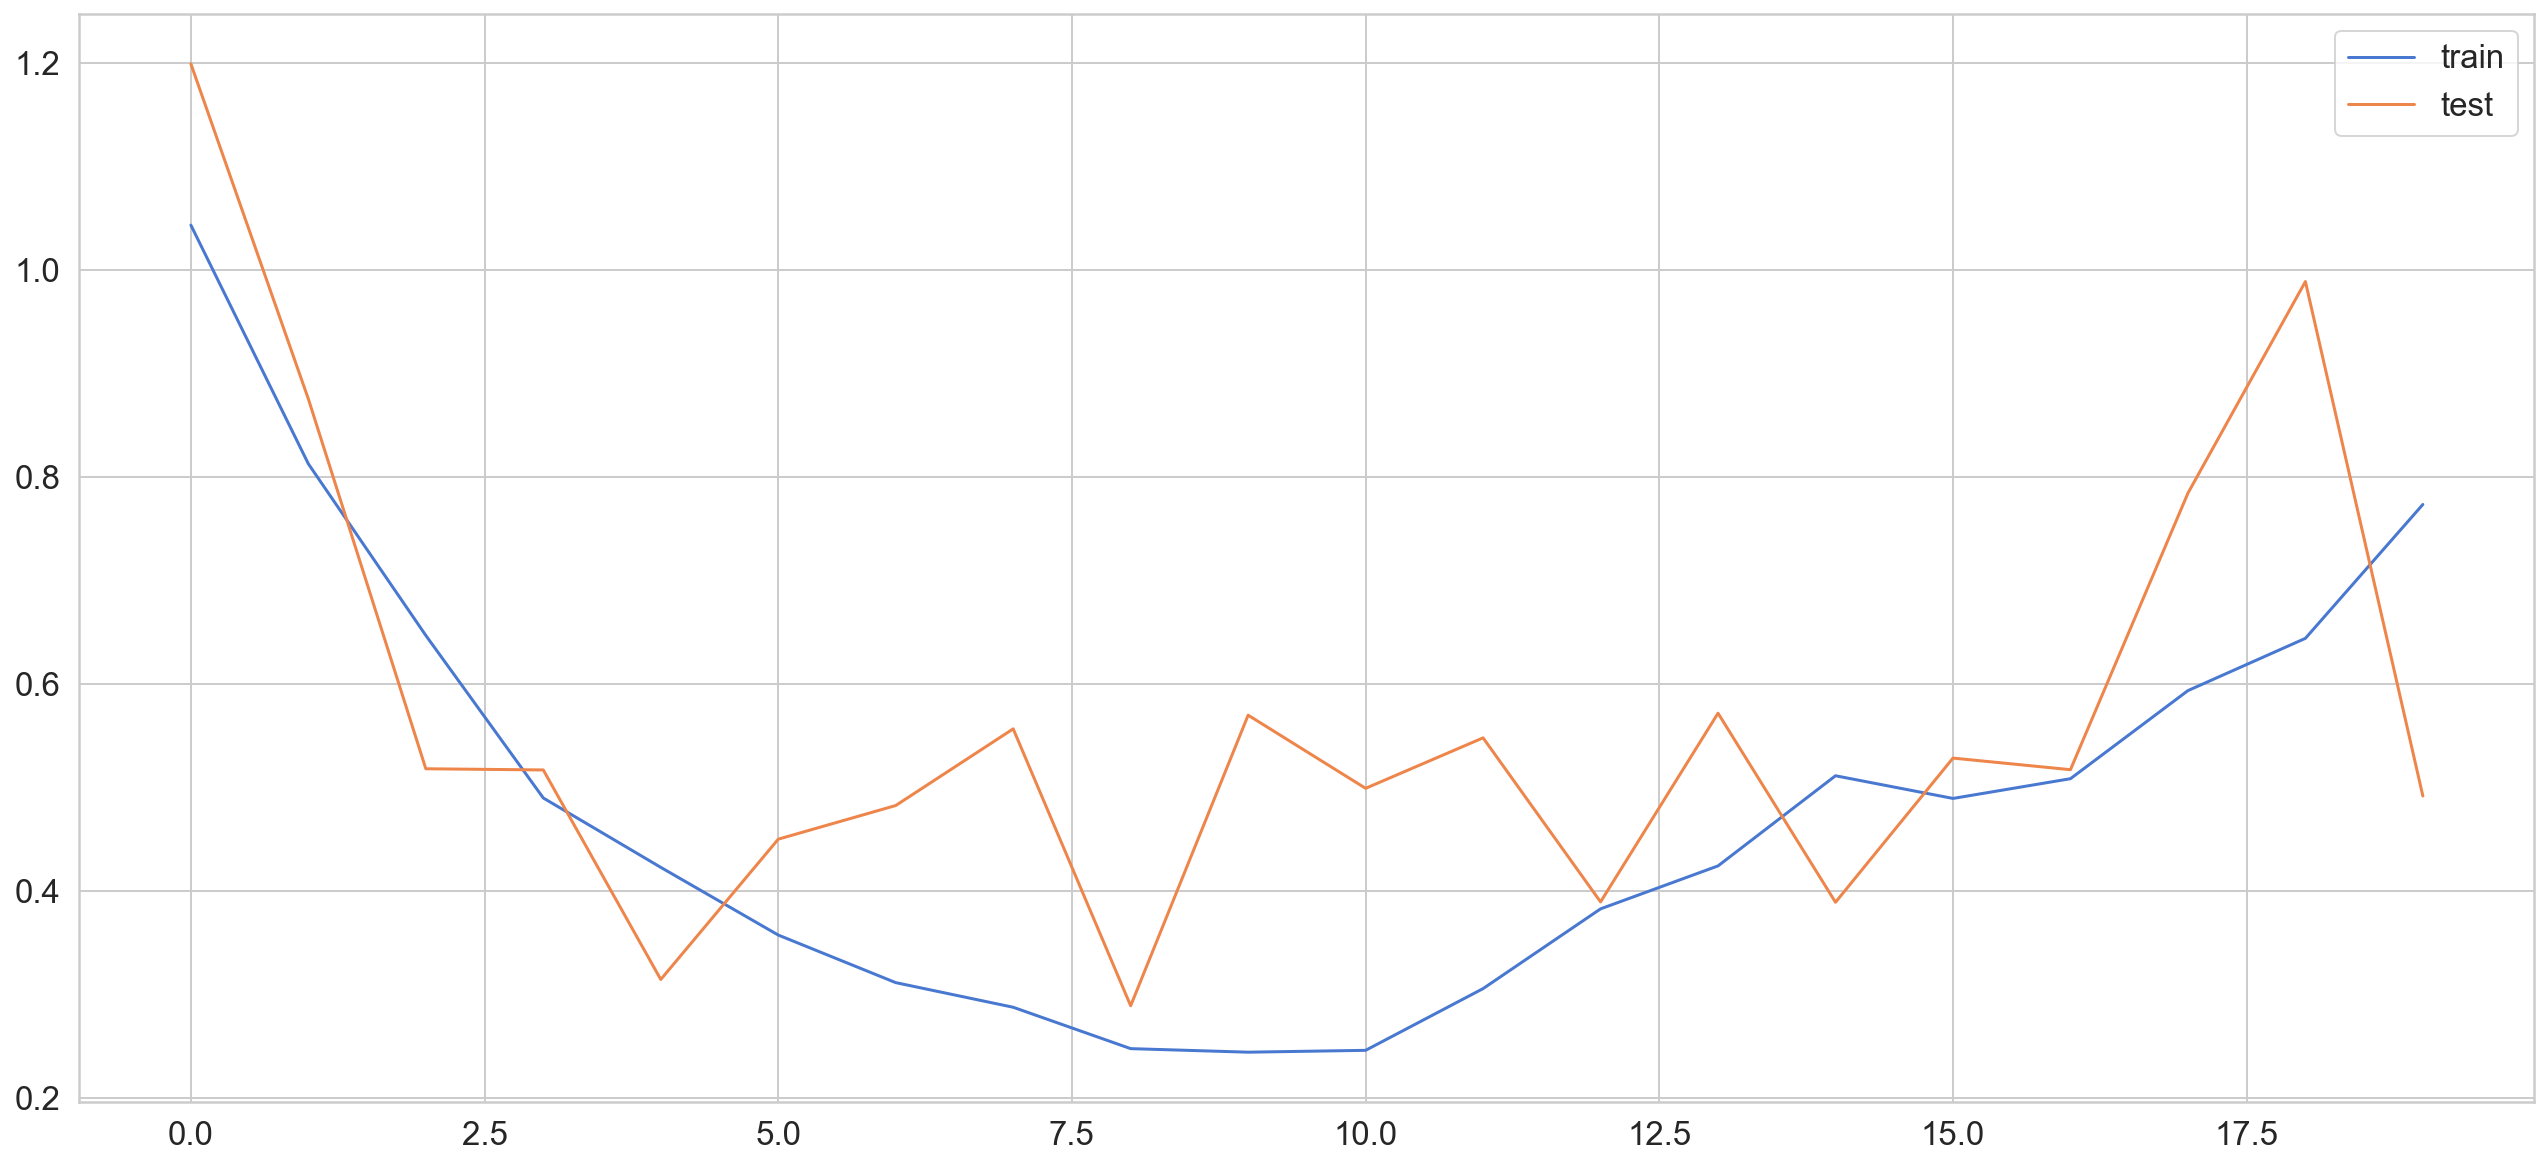

In [12]:
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "test")
plt.legend()

In [13]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

156/156 [==============================] - 10s 58ms/step - loss: 0.5789 - acc: 0.8025


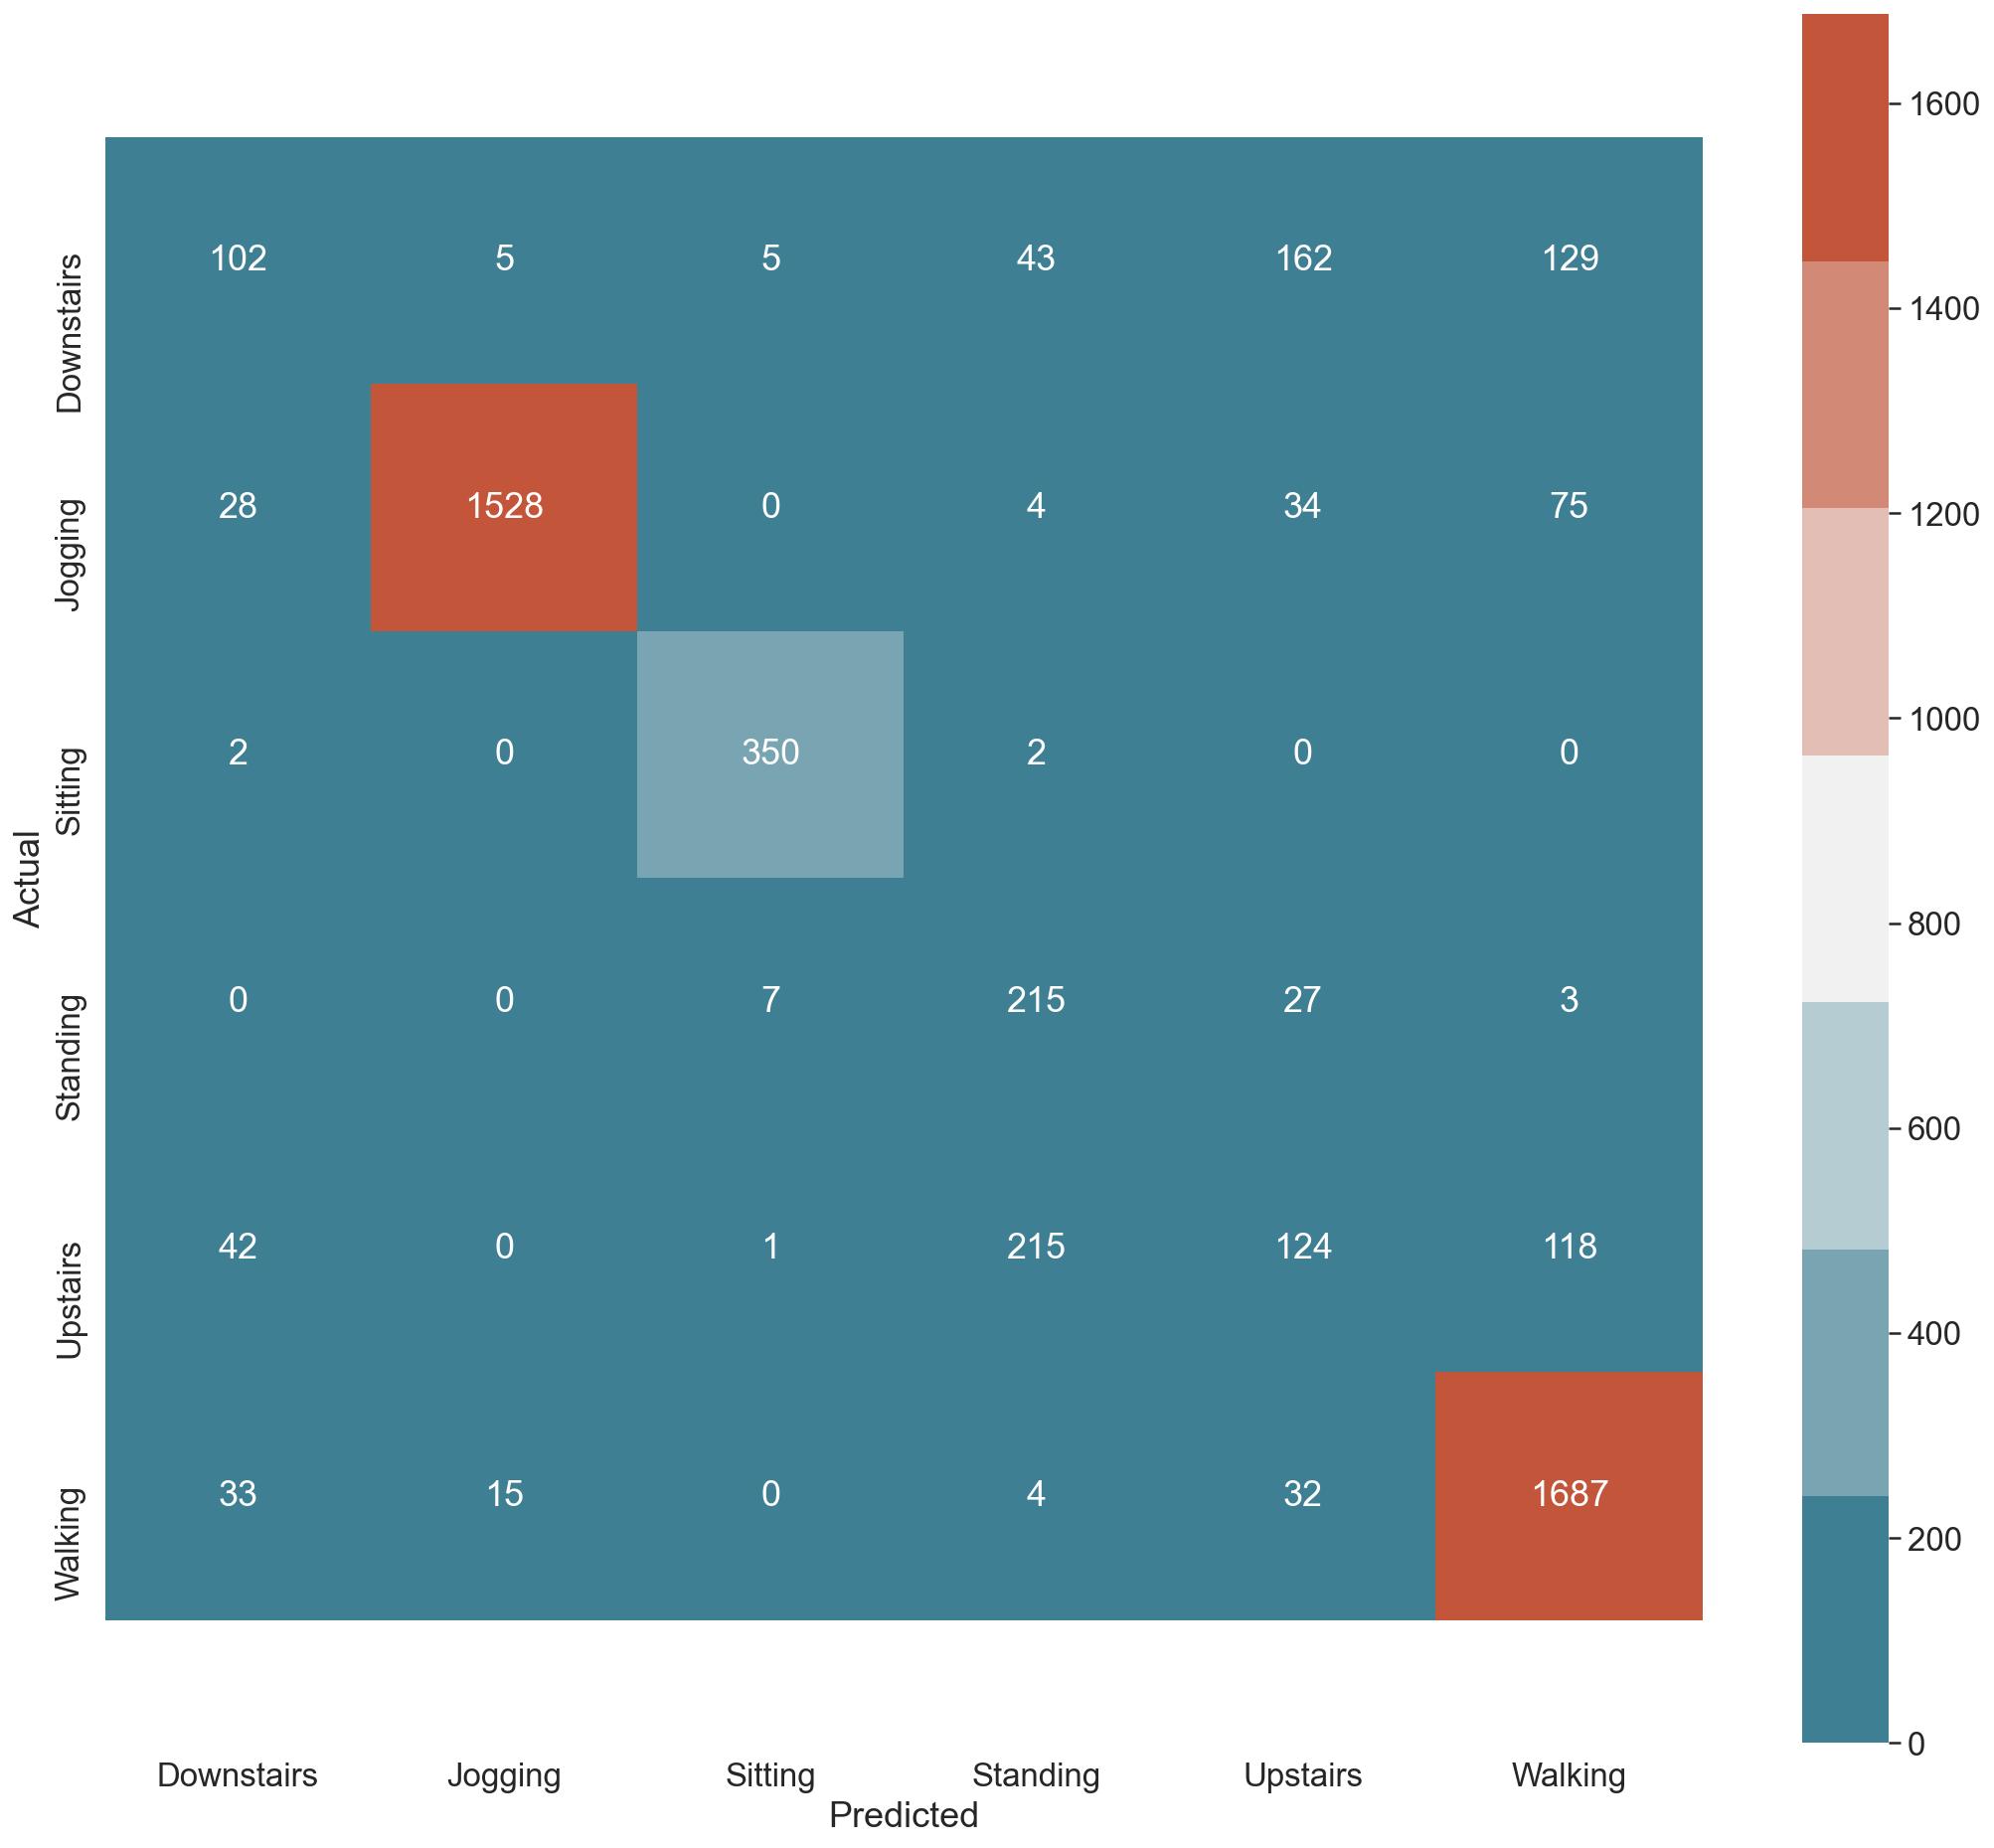

In [14]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(18, 16)) 
    ax = sns.heatmap(cm, annot = True, fmt = "d", cmap = sns.diverging_palette(220, 20, n = 7), ax = ax)

    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()
    
plot_cm(enc.inverse_transform(y_test), enc.inverse_transform(y_pred), enc.categories_[0])